In [300]:
%reload_ext autoreload
%autoreload 2
from spice_net import *
from helpers import *
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Prelim

### Building a toy netlist with diodes

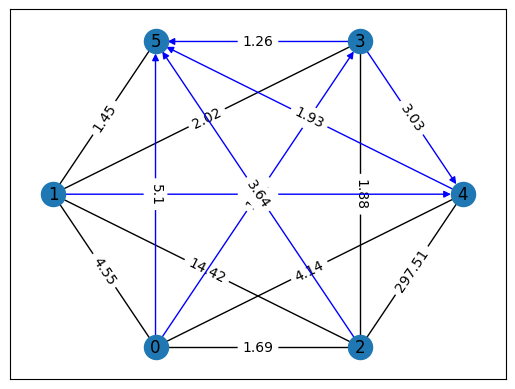

In [97]:
G = nx.erdos_renyi_graph(n=6, p=1)
thresh = 0.5
for u, v in G.edges():
    G[u][v]['weight'] = 1/np.random.rand()
    if np.random.rand() > thresh:
        G[u][v]['type'] = 'diode'
    else:
        G[u][v]['type'] = 'resistor'

vd = NonLinearNetwork('voltage_divider', con_graph=G, node_cfg=(np.array([]), np.array([])), epsilon=1e-16)
visualize(vd)

### Looking at inputs, outputs, and updates on toy dataset

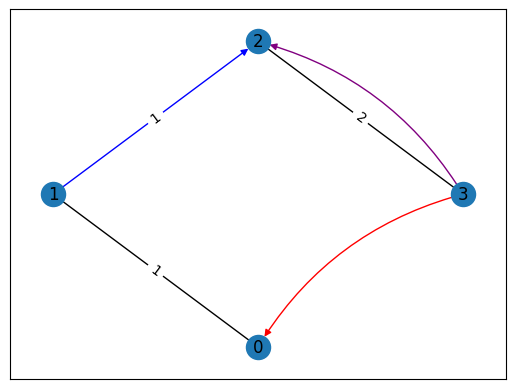

In [98]:
test_G = nx.Graph()
test_G.add_nodes_from(list(range(4)))
test_G.add_edge(0, 1, type='resistor', weight=1)
test_G.add_edge(1, 2, type='diode', weight=1)
test_G.add_edge(2, 3, type='resistor', weight=2)
test = NonLinearNetwork('test', test_G, node_cfg=([[0, 3]], [[2, 3]]))
visualize(test)

In [99]:
print(test)

.title test
.subckt e1 t_in t_out
R1 t_in dummy 1
D1 dummy t_out ReLu
.ends e1
B1 0 3
B2 2 3
Vindex index 0 1
R1 0 1 1
R2 2 3 2
X1 1 2 e1
.model ReLu D (js=0 n=0.001)



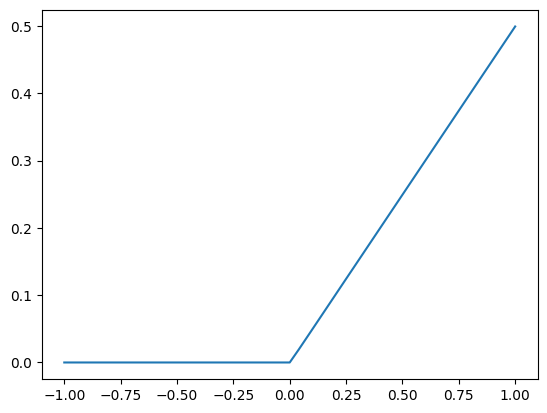

In [100]:
xs = np.linspace(-1, 1, 51)
plt.plot(xs, test.predict(xs[:, None]).squeeze())

### Handmade absolute value function example

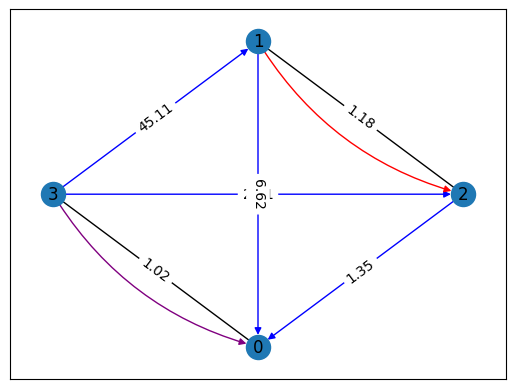

In [326]:
con_graph = nx.DiGraph()
con_graph.add_nodes_from(list(range(4)))

con_graph.add_edge(2, 1, type='resistor', weight=1./np.random.rand())
con_graph.add_edge(0, 3, type='resistor', weight=1./np.random.rand())

con_graph.add_edge(3, 1, type='diode', weight=1./np.random.rand())
con_graph.add_edge(2, 0, type='diode', weight=1./np.random.rand())
con_graph.add_edge(1, 0, type='diode', weight=1./np.random.rand())
con_graph.add_edge(3, 2, type='diode', weight=1./np.random.rand())

node_cfg = [[[2, 1]], [[0, 3]]]

handmade = NonLinearNetwork('handmade', con_graph, node_cfg)
visualize(handmade)

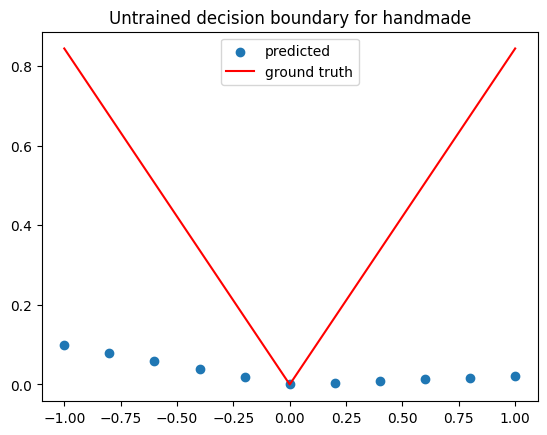

In [327]:
m = np.random.random()
model = lambda x: np.abs(m*x)

lh = 1
num_pts = 11
xs = np.linspace(-lh, lh, num_pts)
ys = handmade.predict(xs[:, None]).squeeze()
# ys = [test_net.predict(x) for x in np.stack((np.linspace(0, lh, num_pts), np.ones(num_pts))).T]
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Untrained decision boundary for {handmade.name}')
plt.legend(['predicted', 'ground truth'])
plt.show()

In [340]:
# Train linear network
epochs = 5
trained_handmade, loss, updates, weights = train(handmade, xs[:,None], model(xs[:, None]), epochs, gamma=1, eta=0.1)

Epoch 1: 0.0004714286989067277
Epoch 2: 0.0001875166352195625
Epoch 3: 0.00014731811086296945
Epoch 4: 0.0002840139241549477
Epoch 5: 9.811446072763526e-05


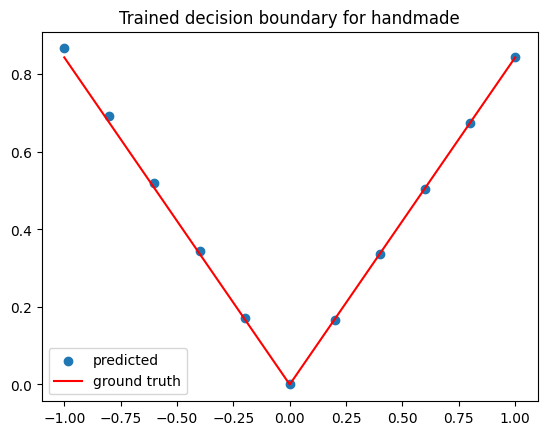

In [341]:
ys = [trained_handmade.predict([x]) for x in xs]
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Trained decision boundary for {handmade.name}')
plt.legend(['predicted', 'ground truth'])
plt.show()

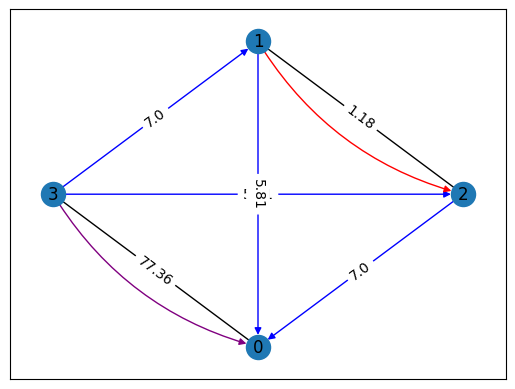

In [342]:
visualize(trained_handmade)

## Training on a nonlinear function

### Generate the dataset

In [585]:
# Generate N random points
N = 15
split = 1.
# pts = np.random.rand(N)
# pts = np.logspace(-2, 0, N)
pts = np.linspace(-1, 1, N)
sigma = 0.000

# Split into training and testing datasets
np.random.shuffle(pts)
training, test = {}, {}
training['x'], test['x'] = pts[:int(N*split), None], pts[int(N*split):, None]

# Generate noninear data
m = 0.01
b = 0

# model = (lambda m, b: lambda x: np.log(m*x + b)/100)(m, b) 
model = (lambda m, b: lambda x: np.abs(m*(x + b)))(m, b)

training['y'] = model(training['x']) + np.random.normal(0, sigma, training['x'].shape)
test['y'] = model(test['x']) + np.random.normal(0, sigma, test['x'].shape)

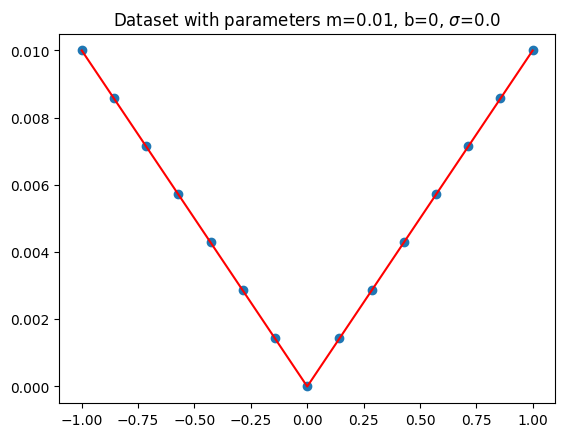

In [586]:
# Visualize dataset
plt.scatter(training['x'], training['y'])
plt.plot(np.sort(training['x'], axis=0), model(np.sort(training['x'], axis=0)), 'r',)
plt.title(fr'Dataset with parameters m={round(m, 3)}, b={round(b, 3)}, $\sigma$={sigma}')
plt.show()

### Nonlinear, no bias voltages

#### Generate random resistor + diode network

In [570]:
# Parameters
nodes = 15
edge_prob = .4
diode_prob = .8

con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob, directed=True)
diodes, res = 0, 0
for u, v in con_graph.edges():
    if np.random.rand() < diode_prob:
        diodes += 1
        con_graph[u][v]['type'] = 'diode'
        con_graph[u][v]['weight'] = 1./np.random.rand() / nodes
    else:
        con_graph[u][v]['type'] = 'resistor'
        con_graph[u][v]['weight'] = 1./np.random.rand() / nodes
        res += 1

print('Num edges:', diodes + res)
print('Num purely resistor:', res)
print('Num diodes:', diodes)

in_nodes = 1
out_nodes = 1
node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])
node_cfg

Num edges: 86
Num purely resistor: 19
Num diodes: 67


(array([[ 7, 11]]), array([[10,  2]]))

In [571]:
nonlin = NonLinearNetwork('nonlinear', con_graph, node_cfg)
# visualize(nonlin)

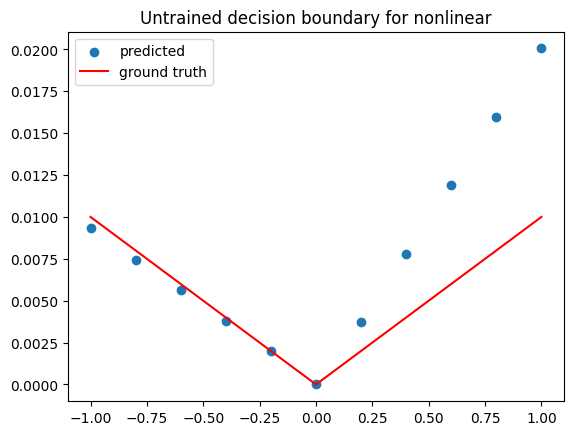

In [587]:
test_net = nonlin
lh = 1
num_pts = 11
xs = np.linspace(-lh, lh, num_pts)
ys = test_net.predict(xs[:, None])
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Untrained decision boundary for {test_net.name}')
plt.legend(['predicted', 'ground truth'])
plt.show()

#### Train network

In [588]:
# Train nonlinear network
epochs = 10
trained_nonlin, loss, updates, weights = train(nonlin, training['x'], training['y'], epochs, gamma=30, eta=0.1)

Epoch 1: 1.817943538003356e-05
Epoch 2: 1.805113286957812e-05
Epoch 3: 1.7928525918907408e-05
Epoch 4: 1.7806654023968004e-05
Epoch 5: 1.768797657672119e-05
Epoch 6: 1.7571746094993484e-05
Epoch 7: 1.7457677312931902e-05
Epoch 8: 1.7346022784995353e-05
Epoch 9: 1.726901991299572e-05
Epoch 10: 1.7128953133891863e-05


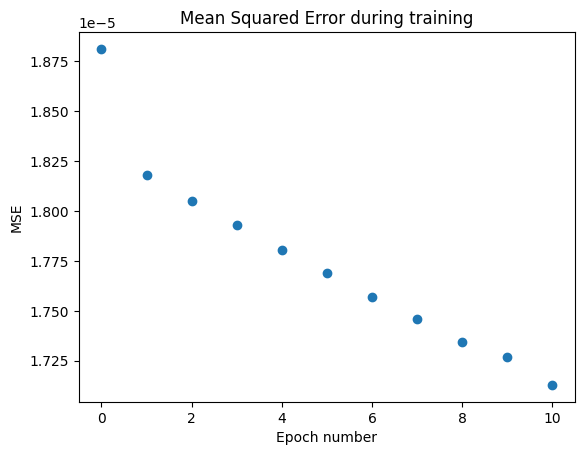

In [589]:
plt.scatter(np.arange(loss.size), loss)
plt.title('Mean Squared Error during training')
plt.xlabel('Epoch number')
plt.ylabel('MSE')
plt.show()

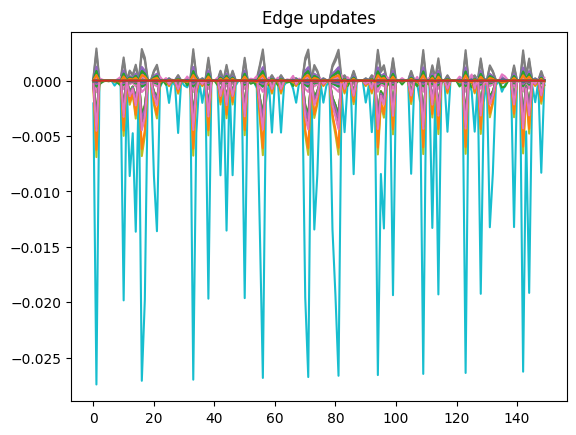

In [590]:
# plt.plot(updates.reshape(-1, updates.shape[-1]))
plt.plot(np.clip(updates.reshape(-1, updates.shape[-1]), -.5, .5))
# plt.plot(np.clip(updates.sum(axis=1), -1, 1))
plt.title('Edge updates')
plt.show()

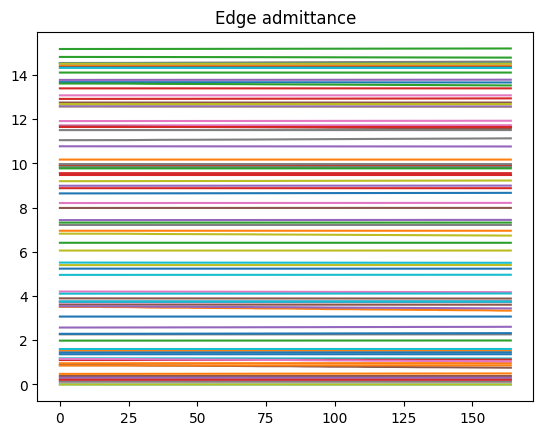

In [591]:
plt.plot(1./weights.reshape(-1, weights.shape[-1]))
# plt.plot(np.clip(1./weights, -np.inf, np.inf))
plt.title('Edge admittance')
plt.show()

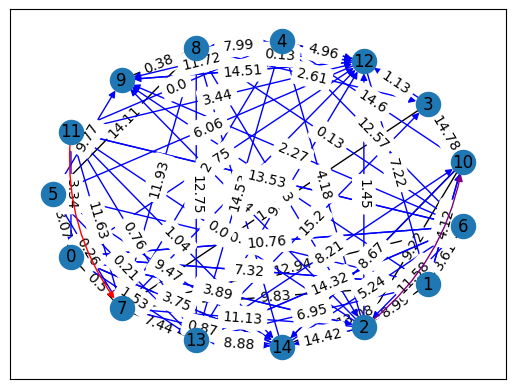

In [592]:
visualize(trained_nonlin, mode='y')

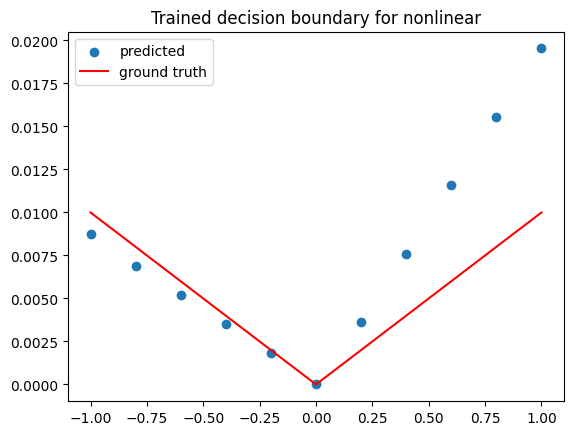

In [593]:
test_net = trained_nonlin
ys = test_net.predict(xs[:, None]).flatten()
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Trained decision boundary for {test_net.name}')
plt.legend(['predicted', 'ground truth'])

plt.show()

### Visualize training results over time

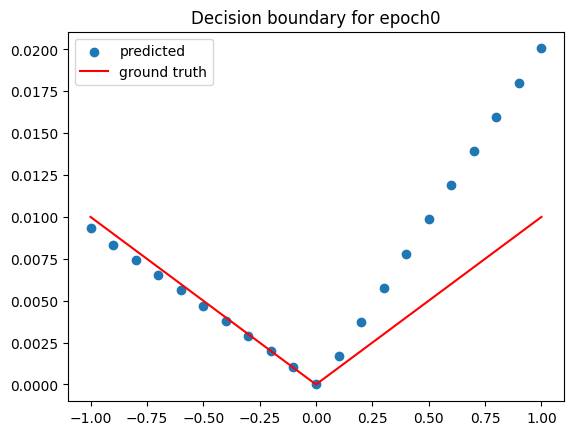

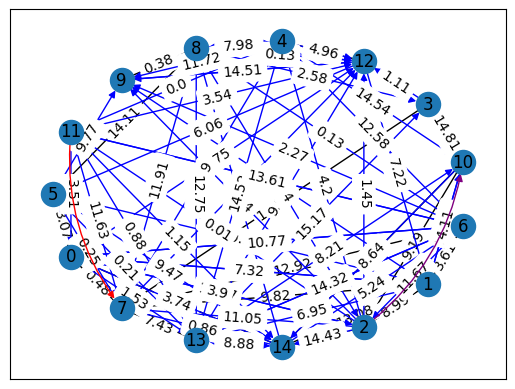

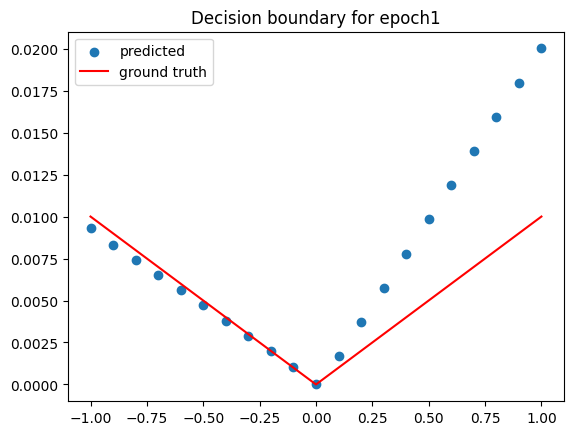

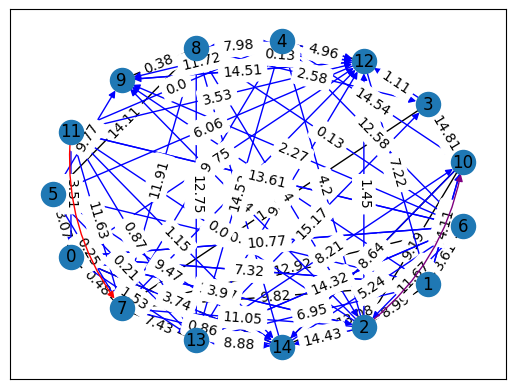

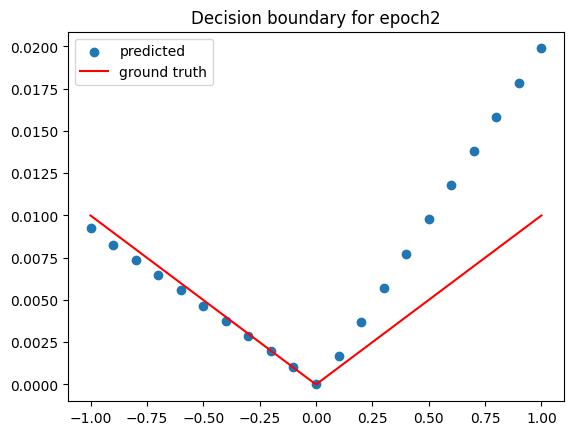

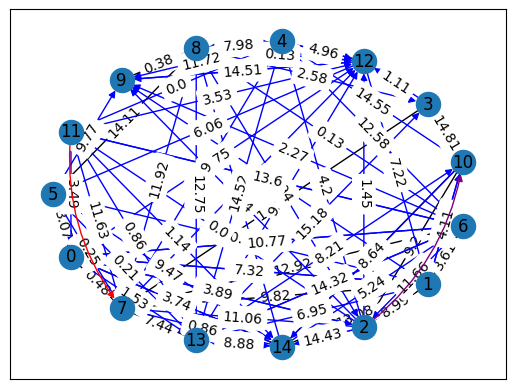

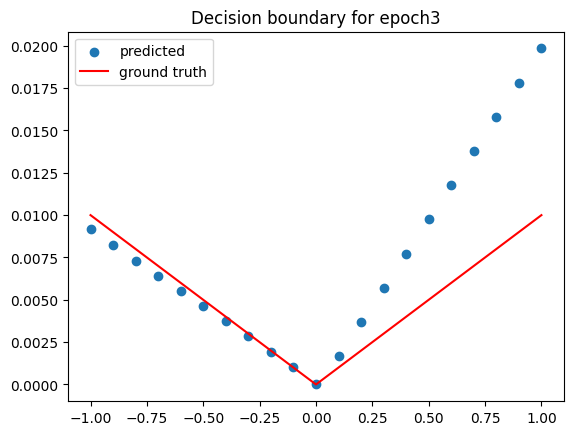

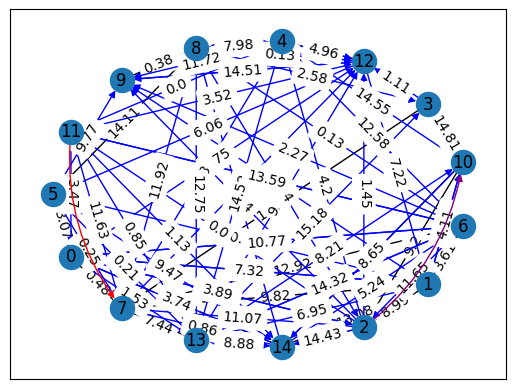

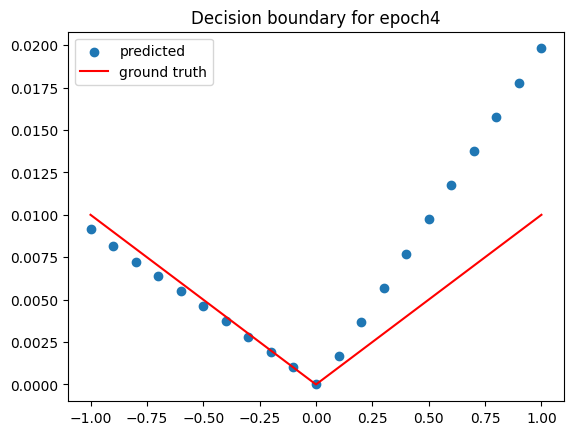

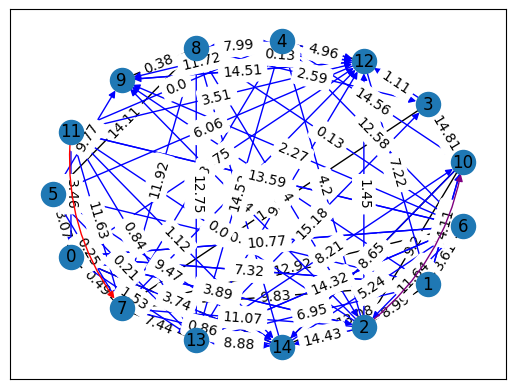

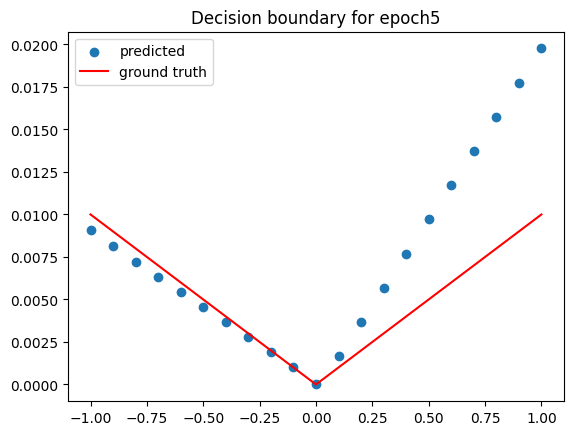

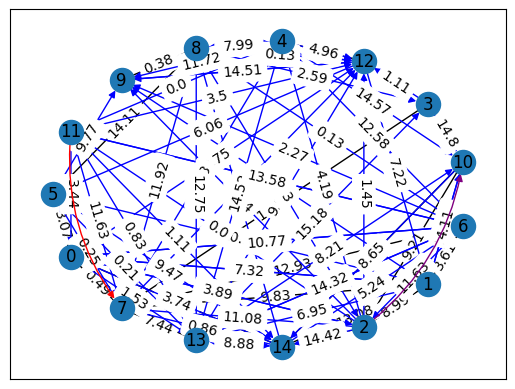

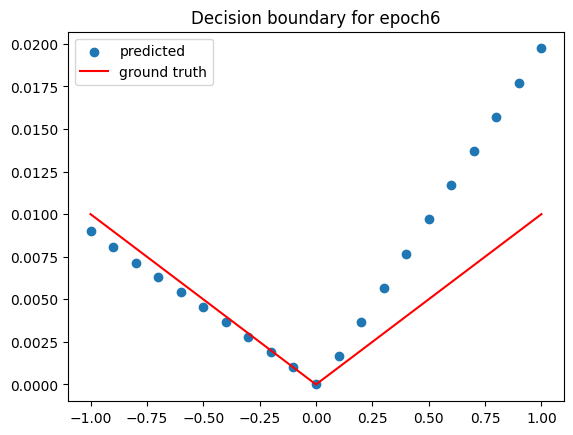

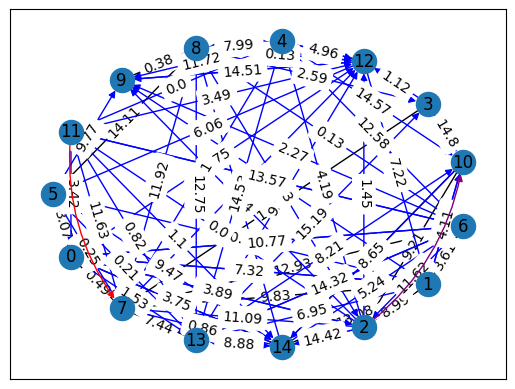

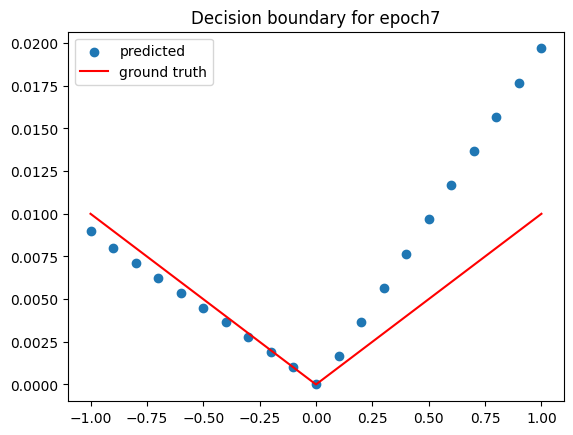

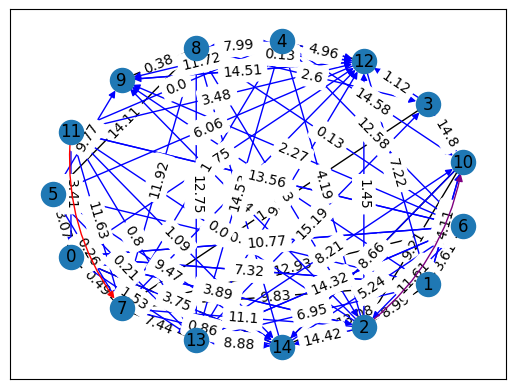

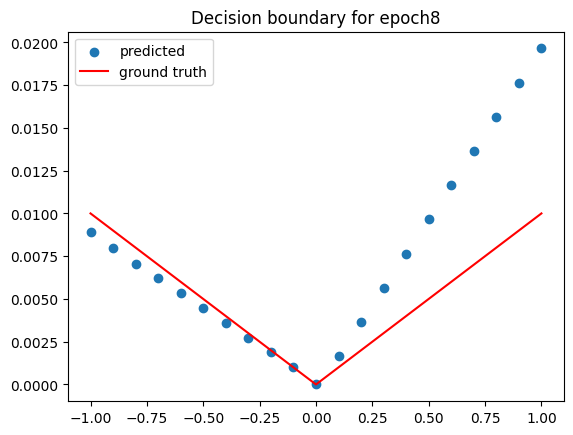

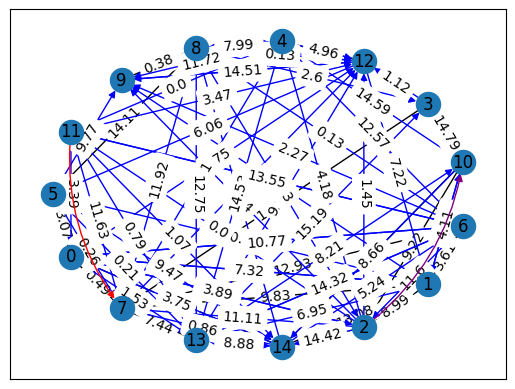

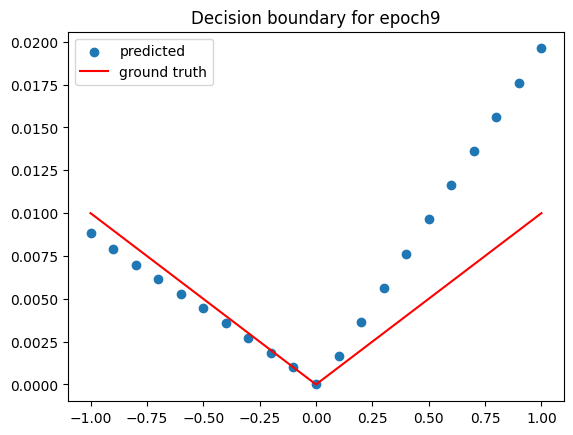

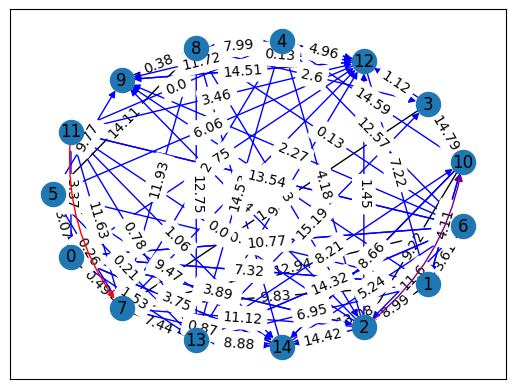

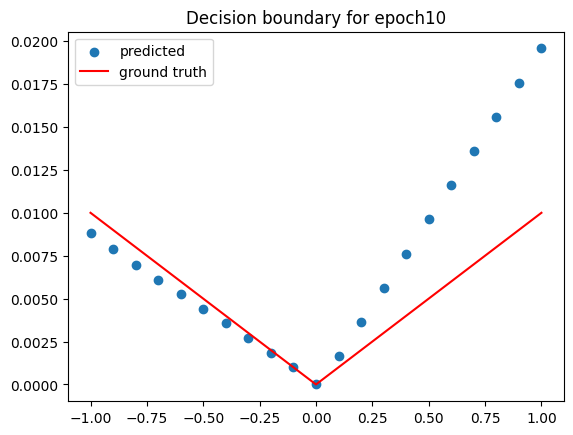

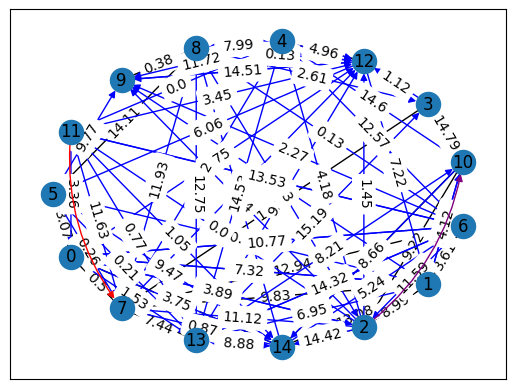

In [595]:
test_net: NonLinearNetwork = nonlin.copy(f'test_net')
for test_it in range(epochs+1):
    for i, R in enumerate(test_net.edges):
        R.resistance = weights[test_it, 0][i]

    for i, X in enumerate(test_net.nonlinear_vals):
        X.R1.resistance = weights[test_it, 0][i + len(test_net.edges)]
    lh = 1
    num_pts = 21
    xs = np.linspace(-lh, lh, num_pts)
    xs_bias = np.hstack((xs[:, None], np.tile(biases, (num_pts, 1))))


    ys = test_net.predict(xs[:,None])
    # ys = test_net.predict(xs_bias)

    plt.scatter(xs, ys)
    plt.plot(xs, model(xs), 'r')
    plt.title(f'Decision boundary for epoch{test_it}')
    plt.legend(['predicted', 'ground truth'])
    plt.show()
    visualize(test_net, mode='y')
    plt.show()

### Retry example with bias terms

In [517]:
# Parameters
nodes = 30
edge_prob = .7
diode_prob = .8

# print('Num edges:', diodes + res)
# print('Num purely resistor:', res)
# print('Num diodes:', diodes)

in_nodes = 4
out_nodes = 1

con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob, directed=True)
diodes, res = 0, 0
for u, v in con_graph.edges():
    if np.random.rand() < diode_prob:
        diodes += 1
        con_graph[u][v]['type'] = 'diode'
        con_graph[u][v]['weight'] = 1./np.random.rand() * nodes
    else:
        con_graph[u][v]['type'] = 'resistor'
        con_graph[u][v]['weight'] = 1./np.random.rand() * nodes
        res += 1

node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])

print('Num edges:', diodes + res)
print('Num purely resistor:', res)
print('Num diodes:', diodes)

nonlin = NonLinearNetwork('nonlinear', con_graph, node_cfg)

Num edges: 604
Num purely resistor: 108
Num diodes: 496


In [529]:
biases = np.random.normal(0, 1, size=in_nodes-1)

In [518]:
# visualize(nonlin)

/var/folders/p1/kynpdwyn2r5fmbpnr8d45m340000gn/T/ipykernel_19671/2944318263.py:17: RuntimeWarning: invalid value encountered in log
  model = (lambda m, b: lambda x: np.log(m*x + b)/100)(m, b)


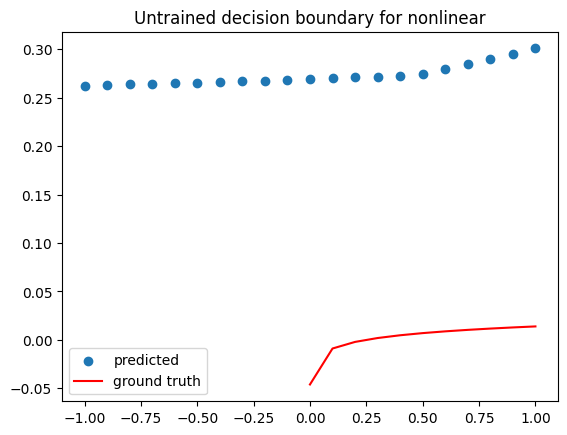

In [531]:
test_net = nonlin
lh = 1
num_pts = 21
xs = np.linspace(-lh, lh, num_pts)
ys = test_net.predict(np.hstack((xs[:, None], np.tile(biases, (num_pts, 1)))))
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Untrained decision boundary for {test_net.name}')
plt.legend(['predicted', 'ground truth'])
plt.show()

#### Train network

In [534]:
# Train nonlinear network
epochs = 10
training_bias = np.hstack((training['x'], np.ones((training['x'].shape[0], 3))))
trained_nonlin, loss, updates, weights = train(nonlin, training_bias, training['y'], epochs, gamma=1000, eta=0.1)

Epoch 1: 7.877032865205822e-05
Epoch 2: 5.989588607042473e-05
Epoch 3: 0.00012589865096990119
Epoch 4: 8.538757081299519e-05
Epoch 5: 0.0002324635620023977
Epoch 6: 0.00014232955157045499
Epoch 7: 0.0001656244060690548
Epoch 8: 5.412361890276223e-05
Epoch 9: 5.909041064177701e-05
Epoch 10: 8.919614040372793e-05


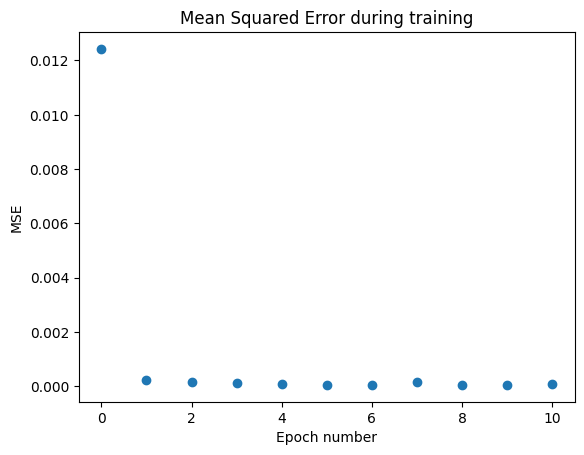

In [521]:
plt.scatter(np.arange(loss.size), loss)
plt.title('Mean Squared Error during training')
plt.xlabel('Epoch number')
plt.ylabel('MSE')
plt.show()

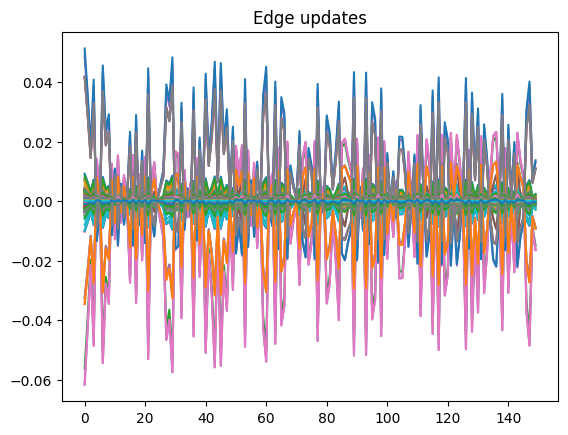

In [514]:
# plt.plot(updates.reshape(-1, updates.shape[-1]))
plt.plot(np.clip(updates.reshape(-1, updates.shape[-1]), -.5, .5))
# plt.plot(np.clip(updates.sum(axis=1), -1, 1))
plt.title('Edge updates')
plt.show()

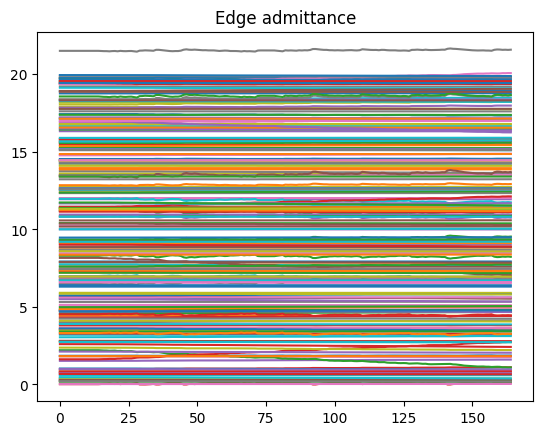

In [476]:
plt.plot(1./weights.reshape(-1, weights.shape[-1]))
# plt.plot(np.clip(1./weights, -np.inf, np.inf))
plt.title('Edge admittance')
plt.show()

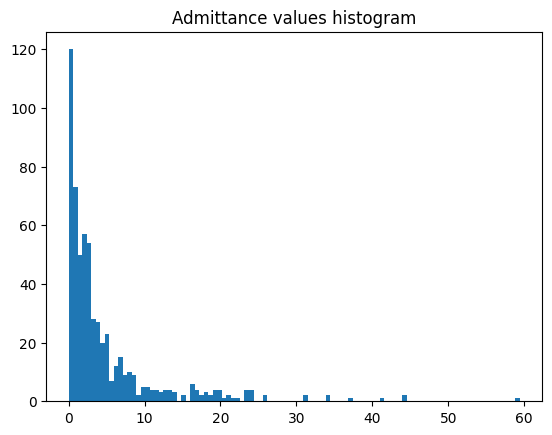

In [544]:
plt.hist(1./weights[-1, -1], bins=100)
plt.title('Admittance values histogram')
plt.show()

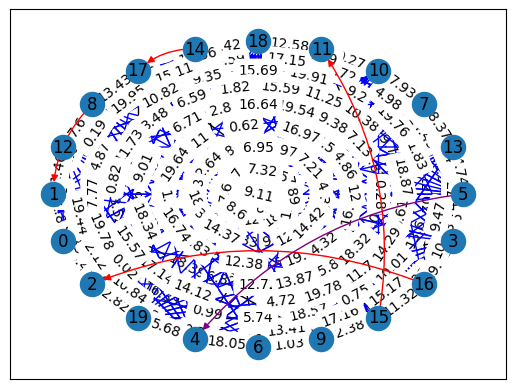

In [470]:
# visualize(trained_nonlin, mode='y')

/var/folders/p1/kynpdwyn2r5fmbpnr8d45m340000gn/T/ipykernel_19671/2944318263.py:17: RuntimeWarning: invalid value encountered in log
  model = (lambda m, b: lambda x: np.log(m*x + b)/100)(m, b)


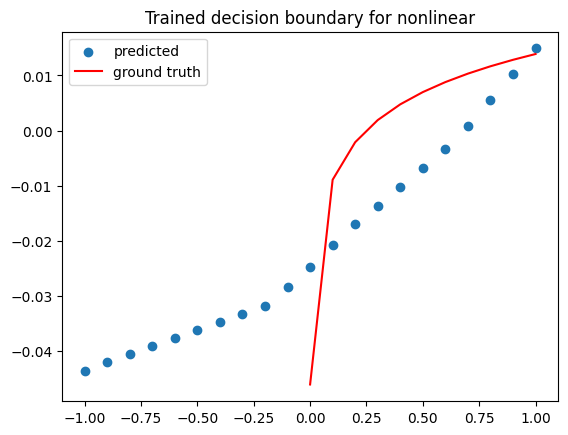

In [522]:
test_net = nonlin
ys = [test_net.predict([x, 1, 1, 1]) for x in xs]
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Trained decision boundary for {test_net.name}')
plt.legend(['predicted', 'ground truth'])

plt.show()